## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams. Some of these scam e-mails have some offensive content. I don't think anything is worse than R-rated, but I just want to warn you that if you start reading the e-mail text, you might read something offensive. If that's a problem, feel free to e-mail me and we can talk about it more or you can skip the assignment.  

### Q1.

Open the `Phishing_Email.parquet` data. It is available at `https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet`, and you can download it directly using Pandas by providing that URL: `df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')`.

We just want to look at the first step of cleaning text data, so you can get an idea of how it works. The `Email Text` variable contains the actual text of the email and the `Email Type` takes the value `Phishing Email` or `Safe Email`. We want to predict which emails are phishing emails from their contents.

Use the `str.split()` method to break the `Phishing Email` values into **tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens. Print the results of your split and examine it.

In words, how would you clean the tokens and use them to predict whether the email is a phishing scam or not? A short summary of the kinds of tasks you would do and how you would run a predictive algorithm is fine.

In [12]:
import numpy as np
import pandas as pd
import pickle
from collections import Counter
from multiprocessing.pool import Pool
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt


#df = pd.read_csv('Phishing_Email.csv')
df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')
tokens = df['Email Text'].str.split()
tokens.head()

,Email Text
0,"[re, :, 6, ., 1100, ,, disc, :, uniformitarian..."
1,"[the, other, side, of, *, galicismos, *, *, ga..."
2,"[re, :, equistar, deal, tickets, are, you, sti..."
3,"[Hello, I, am, your, hot, lil, horny, toy., I,..."
4,"[software, at, incredibly, low, prices, (, 86,..."


In [14]:
import numpy as np
import pandas as pd
import pickle
from collections import Counter
from multiprocessing.pool import Pool
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt


#df = pd.read_csv('Phishing_Email.csv')
df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')
tokens = df['Email Text'].str.split()
# tokens.head() # no need to display this
all_tokens = [token for sublist in tokens for token in sublist] # flatten the list of tokens

# save it to a file for future use if needed
# with open('all_tokens.pickle', 'wb') as file:
#     pickle.dump(all_tokens, file)

> To clean the data, I removed punctuation, common stop words (e.g., "and," "the"), and numbers, then one-hot-encoded the tokens as predictors for each email. Using these features, I applied PCA and linear models to analyze how token presence predicts whether an email is a scam.

### Q2.

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

<Axes: >

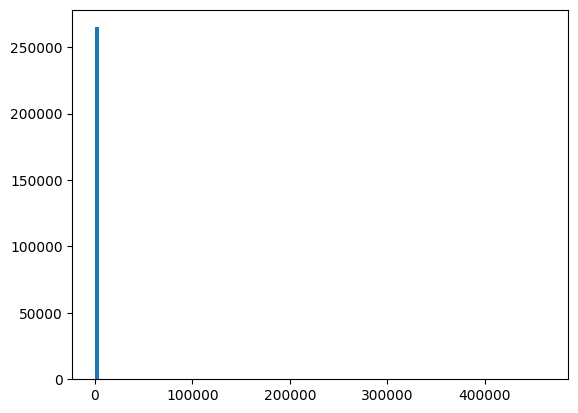

In [15]:
from collections import Counter

# Instead of trying to load the file, which does not exist,
# you can use the all_tokens variable that you generated in the first cell.
#with open('all_tokens.pickle', 'rb') as file:
#    all_tokens = pickle.load(file)

token_count = Counter(all_tokens)
token_freq = token_count.most_common()

gdf = pd.DataFrame(token_freq,columns=['token','count'])
gdf['count'].hist(grid=False,bins=100)

Plot a histogram of the occurrences of tokens. What do you notice about the frequency of occurrence of different tokens? How does it look?

In [16]:
gdf['count'].describe()


,count
count,265111.000000
mean,37.616455
std,1773.074927
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,462537.000000


> The token distribution is highly skewed: most tokens appear only once, with a few exceeding 10 occurrences, and the maximum appearing 1,365 times. This creates challenges, as rare tokens lack predictive power for scams, while overly common tokens like "the" or "and" are similarly uninformative.



### Q3.

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.
2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?
3. What words have the largest coefficients in absolute value and most strongly influence predictions?

In [21]:
# Instead of pd.read_csv, use pd.read_parquet to read a Parquet file:
#df = pd.read_parquet('Phishing_clean.parquet')
df = pd.read_parquet('/content/sample_data/Phishing_Email.parquet')

# The rest of your code remains the same:
y = df['Email Type']
X = df.drop('Email Type',axis=1)

## 1.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=125)

## 2.
lm_0 = LinearRegression(fit_intercept=False).fit(X_train,y_train)
y_hat_test_0 = lm_0.predict(X_test)
y_hat_train_0 = lm_0.predict(X_train)
print('train: ', r2_score(y_hat_train_0,y_train) )
print('test: ', r2_score(y_hat_test_0,y_test) )

OSError: Corrupt snappy compressed data.

In [22]:
## 3.

rdf = pd.DataFrame({'variable':lm_0.feature_names_in_ , 'value':lm_0.coef_})
rdf['abs'] = np.abs(rdf['value'])
rdf.sort_values('abs',ascending=False)

NameError: name 'lm_0' is not defined

> The top variables identified are primarily numbers. I expected more obvious indicators of scams. However, this highlights the potential advantage of using PCA. While the model performs well on the training set with an \( R^2 \) of 0.62, it struggles on the test set, performing only slightly better than predicting the mean—indicating overfitting due to 2,611 likely correlated features.

### Q4.

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

In [ ]:
reduction = PCA(n_components=2).fit(X_train)
Z_train = reduction.transform(X_train)
Z_test = reduction.transform(X_test)
sns.scatterplot(x=Z_test[:,0],y=Z_test[:,1],hue=y_test)

> The orange dots, representing scams, generally have a high second component and low first component, and the model aims to separate them from the blue dots.

### Q5.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

In [23]:
reduction = PCA(n_components=2610).fit(X_train)
Z_train = reduction.transform(X_train)
Z_test = reduction.transform(X_test)

lm_k = LinearRegression().fit(Z_train,y_train)
y_hat_test = lm_k.predict(Z_test)
y_hat_train = lm_k.predict(Z_train)

print('Train r2: ', r2_score(y_hat_train,y_train) )
print('Test r2: ', r2_score(y_hat_test,y_test) )

NameError: name 'X_train' is not defined

Train r2:  0.692897536096376
Test r2:  0.5873905973217197

> This is much better performance than the vanilla linear regression: 0.587 R^2
 rather than basically 0 for the simple linear model, and much closer to the training
 R^2 of 0.692.

### Q6.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.

> PCA eliminates multicollinearity by making features orthogonal, simplifying the selection of components to include, but it sacrifices interpretability since components cannot be directly linked to specific words.